In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)

In [4]:
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

In [5]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.cpu().t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.cpu().t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data.to(**tkwargs)).cpu()
    pareto = is_non_dominated(z).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

## Problem

The approximated pareto set and pareto front is shown in the following figure.

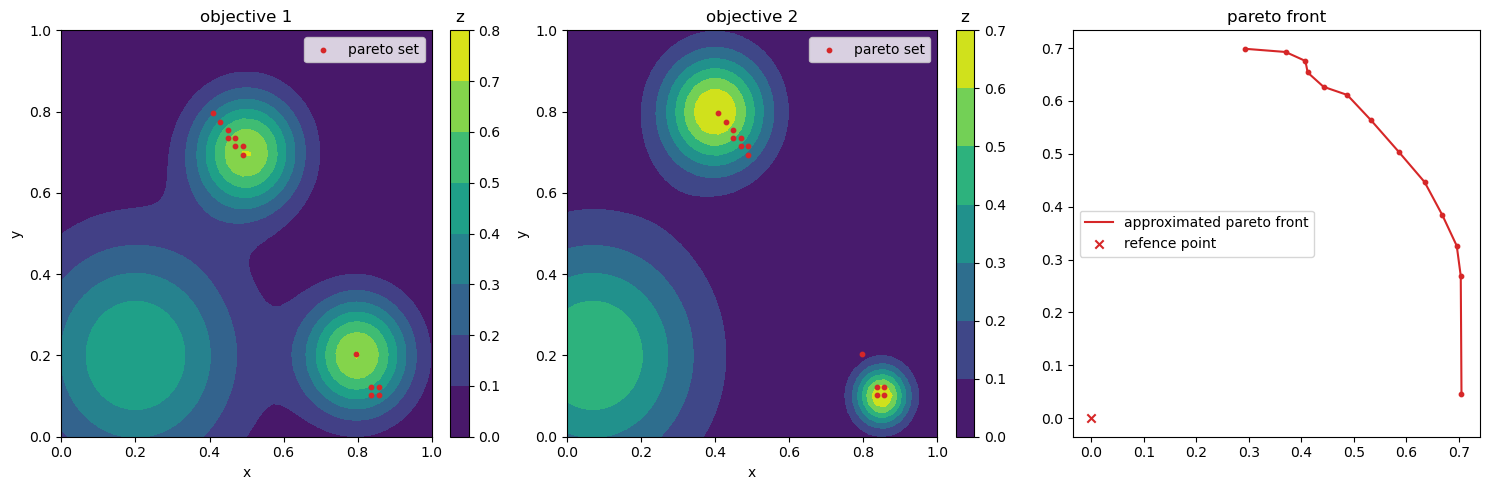

In [6]:
plot_objective(problem, num_samples=50)

In [7]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

# def generate_initial_data(problem, n=6):
#     X_obs = torch.empty(0, problem.bounds.shape[-1])
#     y_obs = torch.empty(0, problem.bounds.shape[-1])
#     while len(X_obs) < n:
#         x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
#         y = problem(x)
#         if (y > problem.ref_point).all(dim=-1).item():
#             X_obs = torch.concat([X_obs, x], dim=0)
#             y_obs = torch.concat([y_obs, y], dim=0)

#     return X_obs, y_obs

In [8]:
init_x, init_y = generate_initial_data(problem, n=50)

## Pareto dominance

**For Maximization**: an objective vector $\mathbf f(\mathbf x)$ Pareto-dominates $\mathbf f (\mathbf x′)$, denoted as $\mathbf f(\mathbf x) \succ \mathbf f(\mathbf x')$, if $f^{(m)}(x) \geq f^{(m)}(x′)$ for all $m = 1, \dots, M$ and there exists at least one $m \in \{1, . . . , M\}$ such that $f^{(m)}(x) > f^{(m)}(x′)$.

## Modeling the objective space

A classifier answers a question that whether the objective value $y$ outperform a certain fraction of point: $\hat \pi(\mathbf x) = p(y \geq \tau \mid \mathbf x)$.

We try to model the separately model the objectives via BORE (PI). For a bi-objective case we have: $$\hat \pi^1 (\mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x)$$ $$ \hat \pi^2 (\mathbf x) = p(y^2 \geq \tau^2 \mid \mathbf x)\,.$$
Assuming the objectives are independent: $$ p(y^1 \geq \tau^1, y^2 \geq \tau^2 \mid \mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x) \cdot p(y^1 \geq \tau^1 \mid \mathbf x)\,. $$
In this case, this convert to determine whether $\mathbf f(\mathbf x)$ weakly dominate a point $(\tau^1, \tau^2)$: $p(\mathbf f(\mathbf x) \succeq \bm \tau)$.

If we jointly model **BORE** with $\gamma$, we can dynamically vary the threshold $(\tau^m)^M_{m=1}$, which allowing us:
- Output the likelihood for different $\bm \tau$
- We can map the current observation to $\bm \tau$: $\bm \tau = \mathbf f(\mathbf x_i)$, and output likelihood that a given $\mathbf x$ outperforming an specific observation $\mathbf x_i$.

## Generate data

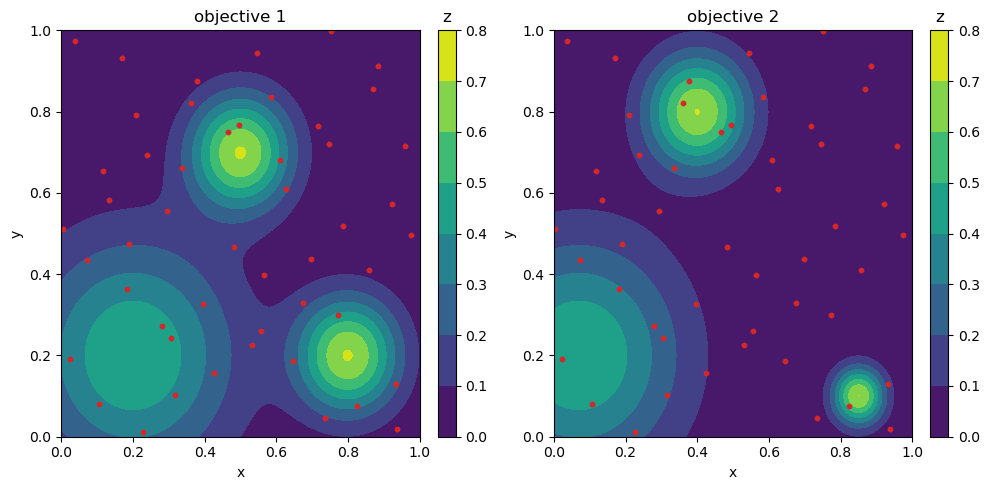

In [9]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.cpu().t()[0], 200
    ),
    np.linspace(
        *problem.bounds.cpu().t()[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data).to(**tkwargs)
z = problem(input_data.to(**tkwargs))

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].cpu().reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [10]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [11]:
from optimizers.lfbo.lfbo_joint_rand import LFBO_JointRand
x_obs = init_x
y_obs = init_y

optimizer_obj_1 = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi', **tkwargs)
optimizer_obj_1.fit(x_obs, -y_obs[:, :1], S=5000)

optimizer_obj_2 = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi', **tkwargs)
optimizer_obj_2.fit(x_obs, -y_obs[:, -1:], S=5000)

Iteration 0


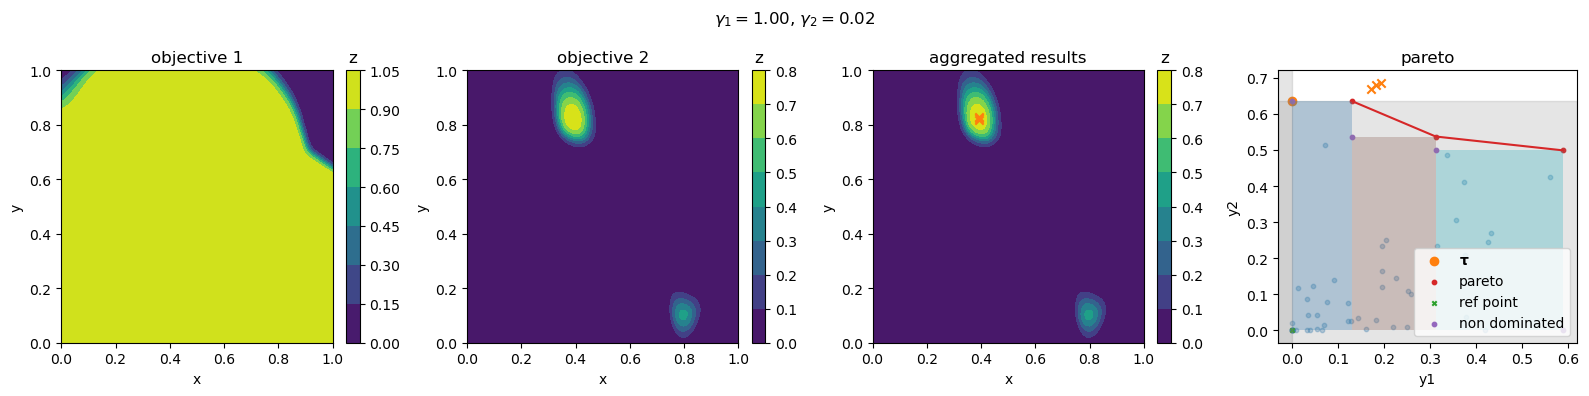

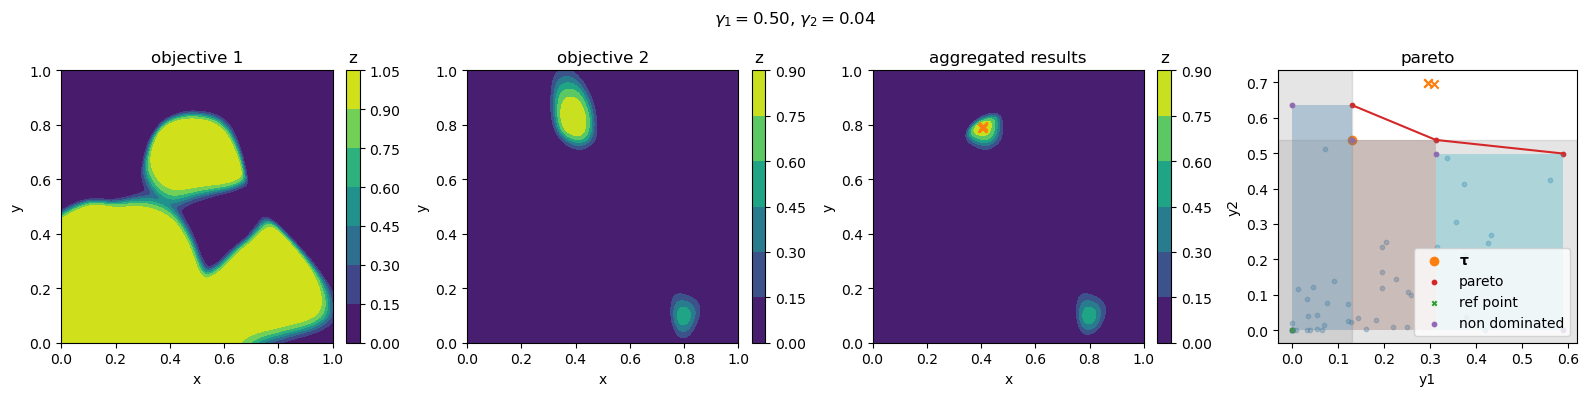

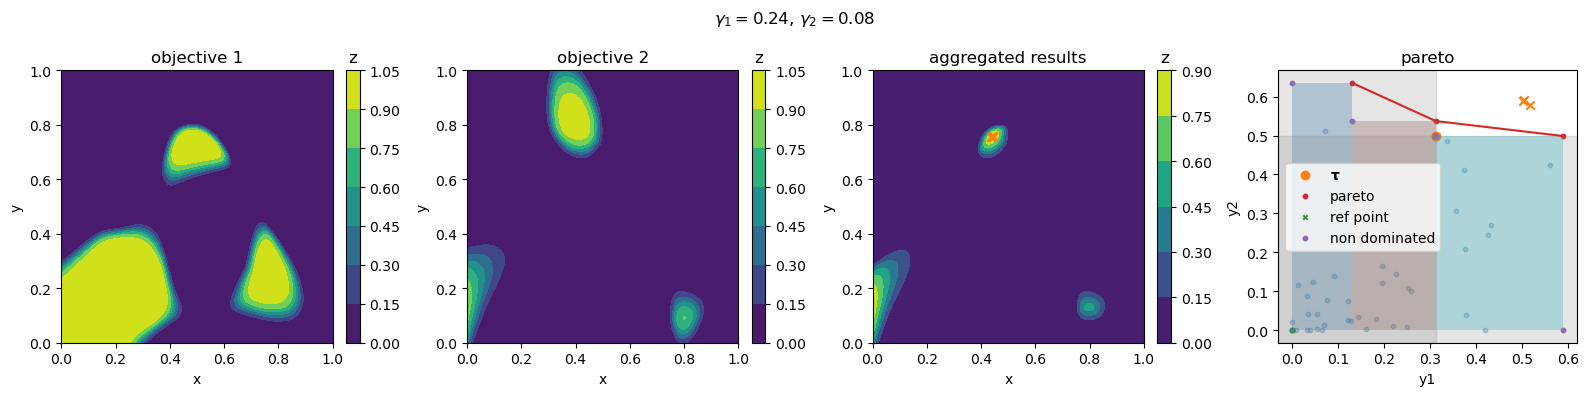

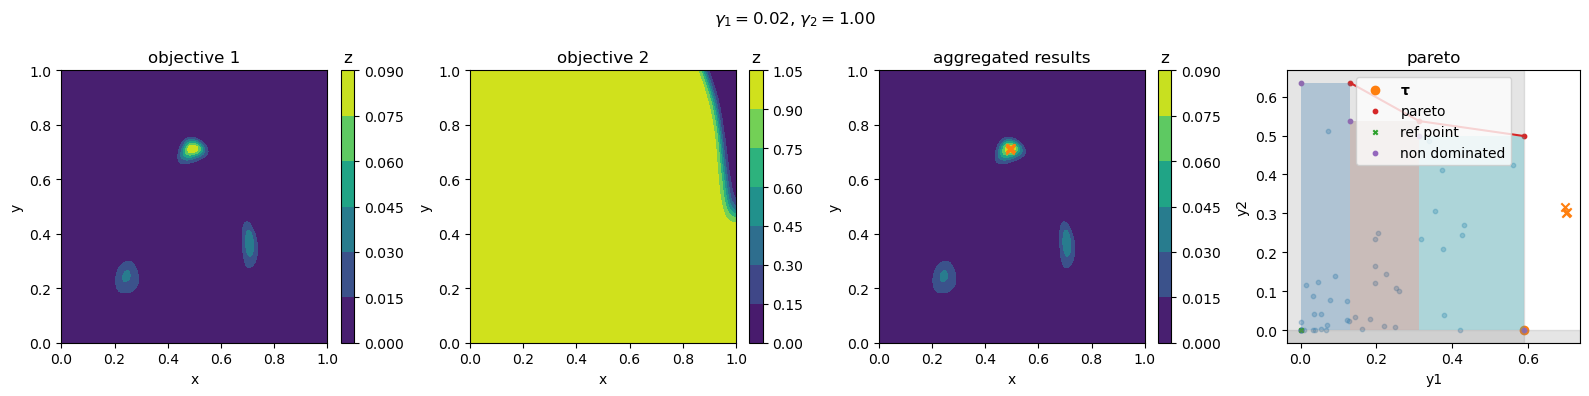

In [12]:
for n in range(1):
    print(f"Iteration {n}")
    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    for ref in u_nbd:
        gamma_1 = ((y_obs[:, 0] >= ref[0]).sum() / len(y_obs)).to(**tkwargs)
        gamma_2 = ((y_obs[:, 1] >= ref[1]).sum() / len(y_obs)).to(**tkwargs)

        fig = plt.figure(figsize=(4* (num_dim + 2), 4))
        optimizers = [optimizer_obj_1, optimizer_obj_2]
        gammas = [gamma_1, gamma_2]
        for i, (optimizer, gamma) in enumerate(zip(optimizers, gammas)):
            ax = plt.subplot2grid((1, num_dim + 2), (0, i))
            div = make_axes_locatable(ax)
            cax = div.append_axes('right', '5%', '5%')

            preds = optimizer.predict(input_data, gamma=gamma)
            # plot functions
            countourset = ax.contourf(
                xx,
                yy,
                preds.cpu().reshape(xx.shape),
            )

            cax.grid(False)  # just to remove the warning
            clb = fig.colorbar(countourset, cax=cax)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title(f"objective {i+1}")
            clb.ax.set_title('z')

        # plot aggregated results
        ax_agg = plt.subplot2grid((1, num_dim + 2), (0, 2))
        div = make_axes_locatable(ax_agg)
        cax = div.append_axes('right', '5%', '5%')
        preds_1 = optimizer_obj_1.predict(input_data, gamma=gamma_1)
        preds_2 = optimizer_obj_2.predict(input_data, gamma=gamma_2)
        preds = preds_1 * preds_2
        vals, inds = torch.topk(preds, k=3)

        countourset = ax_agg.contourf(
            xx,
            yy,
            preds.cpu().reshape(xx.shape),
        )
        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax_agg.scatter(*input_data[inds].cpu().t(), marker='x', color='tab:orange', label='candidates')
        # ax_agg.scatter(*x_obs.t(), s=10, color='tab:red', label='obs')

        ax_agg.set_xlabel('x')
        ax_agg.set_ylabel('y')
        ax_agg.set_title(f"aggregated results")
        clb.ax.set_title('z')

        # plot pareto results
        ax_pareto = plt.subplot2grid((1, num_dim + 2), (0, 3))
        ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)

        tau_1 = -torch.quantile(-torch.unique(y_obs[:, 0]), q=gamma_1, interpolation='lower')
        tau_2 = -torch.quantile(-torch.unique(y_obs[:, 1]), q=gamma_2, interpolation='lower')
        ax_pareto.scatter(tau_1.cpu(), tau_2.cpu(), label=r"$\mathbf{\tau}$")

        ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
        ax_pareto.plot(*l.cpu().t(), color='tab:red')

        pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
        pc.set_array(torch.arange(0, len(l)))
        ax_pareto.add_collection(pc)

        ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
        ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')

        y_cand = problem(input_data[inds])
        ax_pareto.scatter(*y_cand.cpu().t(), marker='x', color='tab:orange')

        # x_obs = torch.concat([x_obs, input_data[inds[0]].unsqueeze(0)])
        # y_obs = torch.concat([y_obs, y_cand[0].unsqueeze(0)])

        x_lim = ax_pareto.get_xlim()
        y_lim = ax_pareto.get_ylim()
        ax_pareto.axhspan(y_lim[0], tau_2.cpu(), alpha=0.2, color='tab:gray')
        ax_pareto.axvspan(x_lim[0], tau_1.cpu(), alpha=0.2, color='tab:gray')
        ax_pareto.set_xlim(*x_lim)
        ax_pareto.set_ylim(*y_lim)

        ax_pareto.set_xlabel('y1')
        ax_pareto.set_ylabel('y2')
        ax_pareto.set_title('pareto')
        ax_pareto.legend()
        
        fig.suptitle(rf"$\gamma_1={gamma_1:.2f}$, $\gamma_2={gamma_2:.2f}$")
        plt.tight_layout()
        plt.show()

Iteration 0


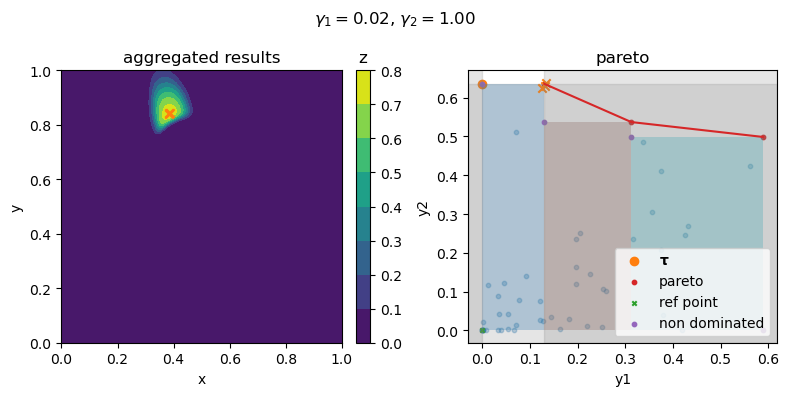

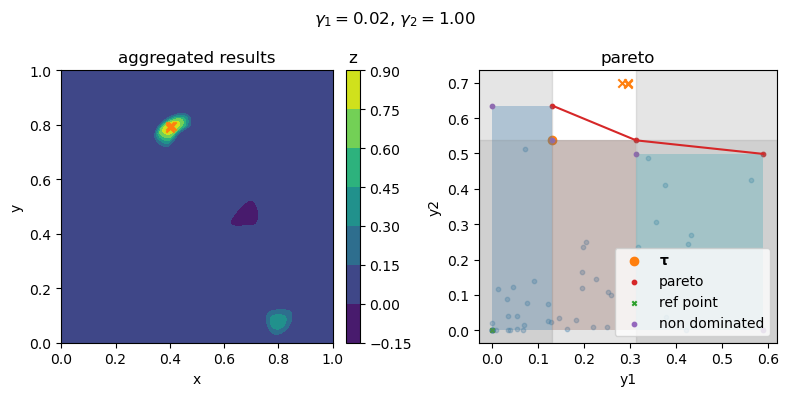

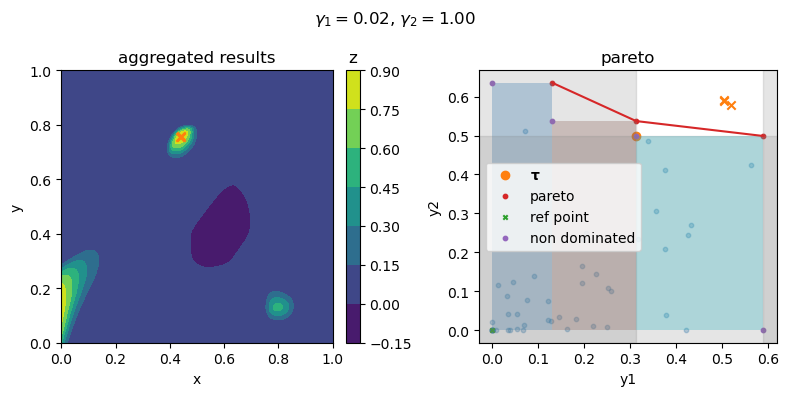

In [17]:
pi_all = []
for n in range(1):
    print(f"Iteration {n}")
    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    for i, lower in enumerate(l):
        upper = u_nbd[i]
        gamma_l_1 = ((y_obs[:, 0] >= lower[0]).sum() / len(y_obs)).to(**tkwargs)
        gamma_l_2 = ((y_obs[:, 1] >= lower[1]).sum() / len(y_obs)).to(**tkwargs)
        gamma_u_1 = ((y_obs[:, 0] >= upper[0]).sum() / len(y_obs)).to(**tkwargs)
        gamma_u_2 = ((y_obs[:, 1] >= upper[1]).sum() / len(y_obs)).to(**tkwargs)

        fig = plt.figure(figsize=(8, 4))
        optimizers = [optimizer_obj_1, optimizer_obj_2]
        gamma_l = [gamma_l_1, gamma_l_2]
        gamma_u = [gamma_u_1, gamma_u_2]

        pi_l = 1.
        for i, (optimizer, gamma) in enumerate(zip(optimizers, gamma_l)):
            pi_l *= optimizer.predict(input_data, gamma=gamma)

        pi_u = 1.
        for i, (optimizer, gamma) in enumerate(zip(optimizers, gamma_u)):
            pi_u *= optimizer.predict(input_data, gamma=gamma)

        ax_agg = plt.subplot2grid((1, 2), (0, 0))
        div = make_axes_locatable(ax_agg)
        cax = div.append_axes('right', '5%', '5%')
        pi_per_region = pi_u - pi_l
        pi_all.append(pi_per_region)
        vals, inds = torch.topk(pi_per_region, k=3)
        countourset = ax_agg.contourf(
            xx,
            yy,
            pi_per_region.cpu().reshape(xx.shape),
        )
        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax_agg.scatter(*input_data[inds].cpu().t(), marker='x', color='tab:orange', label='candidates')

        ax_agg.set_xlabel('x')
        ax_agg.set_ylabel('y')
        ax_agg.set_title(f"aggregated results")
        clb.ax.set_title('z')

        # plot pareto results
        ax_pareto = plt.subplot2grid((1, 2), (0, 1))
        ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)

        l1 = -torch.quantile(-torch.unique(y_obs[:, 0]), q=gamma_l_1, interpolation='lower')
        l2 = -torch.quantile(-torch.unique(y_obs[:, 1]), q=gamma_l_2, interpolation='lower')
        u1 = -torch.quantile(-torch.unique(y_obs[:, 0]), q=gamma_u_1, interpolation='lower')
        u2 = -torch.quantile(-torch.unique(y_obs[:, 1]), q=gamma_u_2, interpolation='lower')
        ax_pareto.scatter(u1.cpu(), u2.cpu(), label=r"$\mathbf{\tau}$")

        ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
        ax_pareto.plot(*l.cpu().t(), color='tab:red')

        pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
        pc.set_array(torch.arange(0, len(l)))
        ax_pareto.add_collection(pc)

        ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
        ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')

        y_cand = problem(input_data[inds])
        ax_pareto.scatter(*y_cand.cpu().t(), marker='x', color='tab:orange')

        x_lim = ax_pareto.get_xlim()
        y_lim = ax_pareto.get_ylim()
        ax_pareto.axhspan(y_lim[0], u2.cpu(), alpha=0.2, color='tab:gray')
        ax_pareto.axvspan(x_lim[0], u1.cpu(), alpha=0.2, color='tab:gray')
        ax_pareto.axvspan(l1.cpu(), x_lim[1], alpha=0.2, color='tab:gray')
        ax_pareto.set_xlim(*x_lim)
        ax_pareto.set_ylim(*y_lim)

        ax_pareto.set_xlabel('y1')
        ax_pareto.set_ylabel('y2')
        ax_pareto.set_title('pareto')
        ax_pareto.legend()
        
        fig.suptitle(rf"$\gamma_1={gamma_1:.2f}$, $\gamma_2={gamma_2:.2f}$")
        plt.tight_layout()
        plt.show()

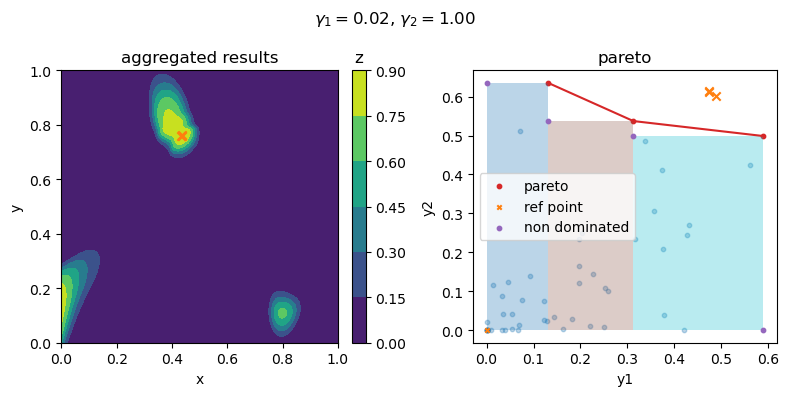

In [18]:
fig = plt.figure(figsize=(8, 4))
ax_agg = plt.subplot2grid((1, 2), (0, 0))
div = make_axes_locatable(ax_agg)
cax = div.append_axes('right', '5%', '5%')

pi = torch.sum(torch.stack(pi_all), dim=0)
vals, inds = torch.topk(pi, k=3)
countourset = ax_agg.contourf(
    xx,
    yy,
    pi.cpu().reshape(xx.shape),
)
cax.grid(False)  # just to remove the warning
clb = fig.colorbar(countourset, cax=cax)
ax_agg.scatter(*input_data[inds].cpu().t(), marker='x', color='tab:orange', label='candidates')
ax_agg.set_xlabel('x')
ax_agg.set_ylabel('y')
ax_agg.set_title(f"aggregated results")
clb.ax.set_title('z')

# plot pareto results
ax_pareto = plt.subplot2grid((1, 2), (0, 1))
ax_pareto.scatter(*y_obs[~pareto].cpu().t(), s=10, alpha=0.3)

ax_pareto.scatter(*l.cpu().t(), s=10, color='tab:red', label="pareto")
ax_pareto.plot(*l.cpu().t(), color='tab:red')

pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
pc.set_array(torch.arange(0, len(l)))
ax_pareto.add_collection(pc)

ax_pareto.scatter(*problem.ref_point.cpu().t(), marker='x', s=10, label="ref point")
ax_pareto.scatter(*u_nbd.cpu().t(), s=10, label="non dominated", color='tab:purple')

y_cand = problem(input_data[inds])
ax_pareto.scatter(*y_cand.cpu().t(), marker='x', color='tab:orange')

x_lim = ax_pareto.get_xlim()
y_lim = ax_pareto.get_ylim()

ax_pareto.set_xlim(*x_lim)
ax_pareto.set_ylim(*y_lim)

ax_pareto.set_xlabel('y1')
ax_pareto.set_ylabel('y2')
ax_pareto.set_title('pareto')
ax_pareto.legend()

fig.suptitle(rf"$\gamma_1={gamma_1:.2f}$, $\gamma_2={gamma_2:.2f}$")
plt.tight_layout()
plt.show()